<a href="https://colab.research.google.com/github/BenzThitikorn/Vector-Symbol-Decoding-with-AI/blob/main/Machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# --- 1.Set Up Environment ---

In [ ]:
# prompt: clear system ram and gpu ram

import gc
import torch

# Clear RAM
gc.collect()
torch.cuda.empty_cache()


In [ ]:
#!git clone https://github.com/BenzThitikorn/Vector-Symbol-Decoding-with-AI.git
#!pip install --upgrade pyldpc
#!pip install livelossplot

In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using {} device".format(device))

Using cuda device


## --- Import Data to train ---

In [ ]:
import numpy as np
X = np.load('/content/drive/MyDrive/VSD + AI/Data Set/(15,30)LDPC/unique_X.npy')
Y = np.load('/content/drive/MyDrive/VSD + AI/Data Set/(15,30)LDPC/unique_Y.npy')
X = np.concatenate((X, np.load('')), axis=axis)
Y = np.concatenate((Y, matrix2), axis=axis)

from sklearn.model_selection import train_test_split
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y^1, train_size= 0.90)

'''
from pyldpc import make_ldpc

d_v = 3  # Variable node degree
d_c = 6  # Check node degree
n = 30 #Code lenght
r = 16 #Symbol lenght
H, Gt = make_ldpc(n, d_v=d_v, d_c=d_c, systematic=True, sparse=True, seed=1)
G = Gt.T  # Transpose of Gt to get G
j = G.shape[0]  # Number of rows in G
print(f"H matrix: {H.shape[0]} rows, {H.shape[1]} columns")
print(f"G matrix: {G.shape[0]} rows, {G.shape[1]} columns")
'''

'\nfrom pyldpc import make_ldpc\n\nd_v = 3  # Variable node degree\nd_c = 6  # Check node degree\nn = 30 #Code lenght\nr = 16 #Symbol lenght\nH, Gt = make_ldpc(n, d_v=d_v, d_c=d_c, systematic=True, sparse=True, seed=1)\nG = Gt.T  # Transpose of Gt to get G\nj = G.shape[0]  # Number of rows in G\nprint(f"H matrix: {H.shape[0]} rows, {H.shape[1]} columns")\nprint(f"G matrix: {G.shape[0]} rows, {G.shape[1]} columns")\n'

# Train

In [ ]:
def update_model(model, loss_fn, opt, train_loader):
    train_loss = 0
    train_correct = 0
    train_count = len(train_loader.dataset)

    for X, y in train_loader:
        X = X.to(device)
        y = y.to(device)
        y_pred = model(X)

        predicted = (y_pred > 0.5).float()
        # Increment train_correct by 1 for each sample where all predicted bits match y
        train_correct += torch.all(predicted == y, dim=1).sum().item()

        loss = loss_fn(y_pred, y)
        train_loss += loss.item() * len(y)

        opt.zero_grad()
        loss.backward()
        opt.step()

    mean_train_loss = train_loss / train_count
    train_accuracy = train_correct / train_count
    return mean_train_loss, train_accuracy

def evaluate_model(model, loss_fn, dataloader):
    model.eval()

    valid_loss = 0
    valid_correct = 0
    valid_count = len(dataloader.dataset)

    for X, y in dataloader:
        X = X.to(device)
        y = y.to(device)
        y_pred = model(X)

        predicted = (y_pred > 0.5).float()
        # Same logic for validation
        valid_correct += torch.all(predicted == y, dim=1).sum().item()

        loss = loss_fn(y_pred, y)
        valid_loss += loss.item() * len(y)

    mean_valid_loss = valid_loss / valid_count
    valid_accuracy = valid_correct / valid_count
    model.train()
    return mean_valid_loss, valid_accuracy

def train(model, loss_fn, opt, train_loader, valid_loader, epoch, scheduler=None, verbose=True):
    if verbose:
        liveloss = PlotLosses()

    for i in range(epoch):
        # Update the model using the training data
        train_loss, train_accuracy = update_model(model, loss_fn, opt, train_loader)

        # Evaluate the model using the validation data
        valid_loss, valid_accuracy = evaluate_model(model, loss_fn, valid_loader)

        # Update the learning rate scheduler (if provided)
        if scheduler:
            scheduler.step()  # This step adjusts the learning rate according to the scheduler

        if verbose:
            # Update live loss plot
            liveloss.update({
                'loss': train_loss,
                'val_loss': valid_loss,
                'accuracy': train_accuracy,
                'val_accuracy': valid_accuracy,
            })
            liveloss.draw()

    if verbose:
        print('Accuracy: {:.4f} (valid), {:.4f} (train)'.format(valid_accuracy, train_accuracy))

    return model


In [ ]:
from torch.optim import Adam,AdamW
from torch.optim.lr_scheduler import StepLR

X_train_flatten = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2])
X_valid_flatten = X_valid.reshape(X_valid.shape[0], X_valid.shape[1]*X_valid.shape[2])

X_train_torch = torch.tensor(X_train_flatten, dtype=torch.float) # Don't forget dtype=torch.float
X_valid_torch = torch.tensor(X_valid_flatten, dtype=torch.float)

Y_train_torch = torch.tensor(Y_train, dtype=torch.float) # Don't forget dtype=torch.long
Y_valid_torch = torch.tensor(Y_valid, dtype=torch.float)

train_dataset = torch.utils.data.TensorDataset(X_train_torch, Y_train_torch)
valid_dataset = torch.utils.data.TensorDataset(X_valid_torch, Y_valid_torch)

In [ ]:
from torch.utils.data import DataLoader

batch_size = 2048  # Adjust based on available GPU memory

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True,
    pin_memory=True, num_workers=4, prefetch_factor=2
)

valid_loader = DataLoader(
    valid_dataset, batch_size=batch_size, shuffle=False,
    pin_memory=True, num_workers=4, prefetch_factor=2
)

input_size = X_train_flatten.shape[1]
output_size = Y_train_torch.shape[1]

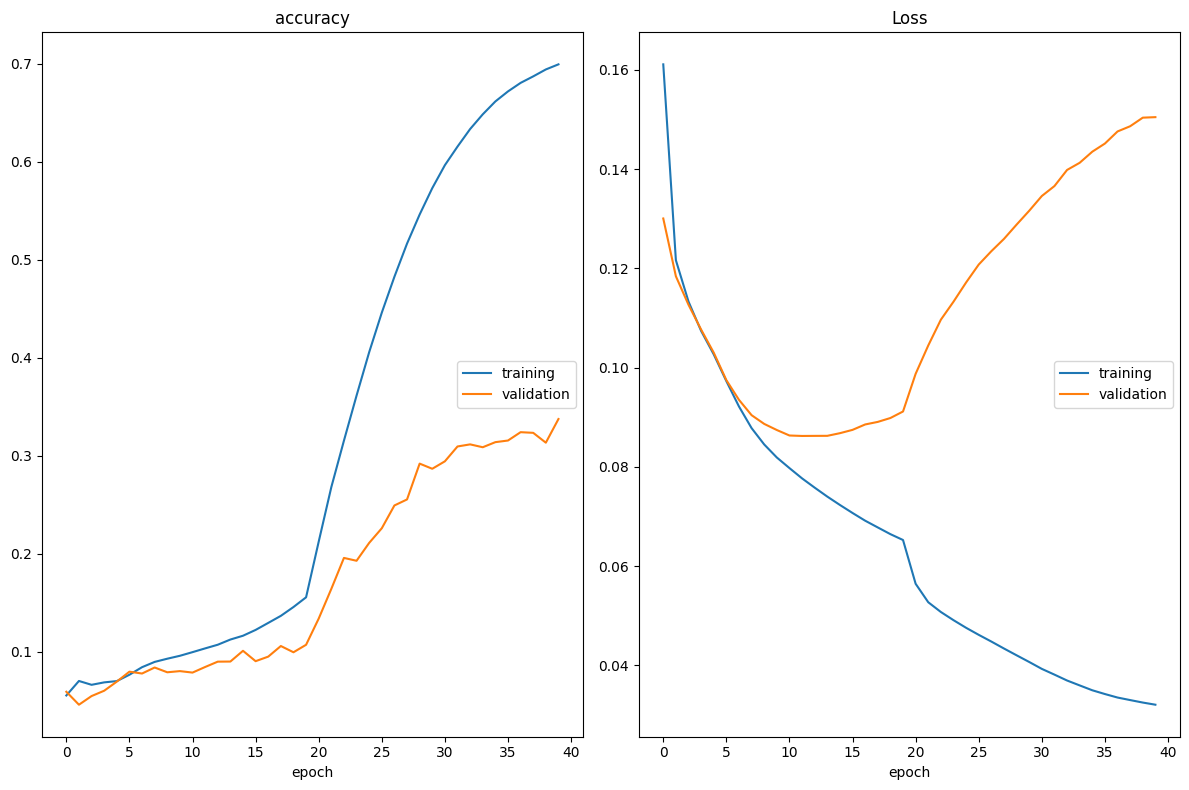

accuracy
	training         	 (min:    0.055, max:    0.699, cur:    0.699)
	validation       	 (min:    0.046, max:    0.337, cur:    0.337)
Loss
	training         	 (min:    0.032, max:    0.161, cur:    0.032)
	validation       	 (min:    0.086, max:    0.150, cur:    0.150)
Accuracy: 0.3374 (valid), 0.6991 (train)


In [ ]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from livelossplot import PlotLosses

#Model 1
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True

mlp_deep = torch.nn.Sequential(
    nn.Linear(input_size, 2048),  # Increase layer size
    nn.Sigmoid(),
    nn.BatchNorm1d(2048),
    #nn.Dropout(0.3),  # Add dropout
    nn.Linear(2048, 1024),
    nn.PReLU(),
    nn.BatchNorm1d(1024),
    #nn.Dropout(0.3),
    nn.Linear(1024, 1024),
    nn.PReLU(),
    nn.BatchNorm1d(1024),
    #nn.Dropout(0.3),
    nn.Linear(1024, 512),
    nn.PReLU(),
    nn.BatchNorm1d(512),
    #nn.Dropout(0.3),
    nn.Linear(512, output_size),
).to(device)

# Prepare loss functions and optimization methods
loss_fn = nn.BCEWithLogitsLoss()
optimizer = AdamW(mlp_deep.parameters(), lr=0.01, weight_decay=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma = 0.5)

trained_model = train(mlp_deep, loss_fn, optimizer, train_loader, valid_loader, epoch=40, scheduler=scheduler)

In [ ]:
#torch.save(mlp_deep.state_dict(), 'mlp_deep_nondecodeonly.pth')


# Test here